In [1]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [2]:
root_dir = os.path.dirname(os.getcwd())
data_filepath = os.path.join(root_dir, 'data/model_data/model_data.csv')

if not os.path.exists(data_filepath):
    raise Exception("Model data file does not exist. Run '/src/process_data.py' to generate model data.")
else:
    df = pd.read_csv(data_filepath)

### To what extent can we optimize boosts to have rides claimed earlier?
Modeling any dynamics between boost size and time is going to be difficult because of the near complete multicollinearity between time, boost number, and boost amount. Including any form of time (`time_elapsed` or `boost_number`) and any standard version of boost amount in the same model will lead to biased coefficients. The correlation between them is high enough that it actually flips on of their signs. The only plausible option is to transform the data to decorrelate time and boost amount. 

To do that, we can get the difference in total boost amount from what is typical for that amount of elapsed time (and, consequently, that boost number) and that metro area. If we can sufficiently decorrelate time and boost amount, we may be able to model the effect of boost size on the expected time until a trip is claimed.

The Cox Proportional Hazard Model predicts the time to an event, which makes it a natural fit for predicting the time until a ride is claimed.

### Cox Proportional Hazard Model

In [3]:
cph = CoxPHFitter()
cph.fit(df[['time_elapsed', 'claimed', 'total_boost', 'total_boost_pct_change_from_avg', 'driver_supply_difference']], duration_col='time_elapsed', event_col='claimed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 119835 total observations, 101713 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'claimed'
      baseline estimation = breslow
   number of observations = 119835
number of events observed = 18122
   partial log-likelihood = -168049.38
         time fit was run = 2024-07-12 16:12:30 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
total_boost                     -0.62      0.54      0.01           -0.63           -0.61                0.53                0.55
total_boost_pct_change_from_avg  0.03      1.03      0.00            0.03            0.03                1.03                1.04
driver_supply_difference        -0.03      0.97      0.06           -0.16            0.09                0.85                1.10

                                 cmp to       z      p  -log2(p)
covariate                                                       
total_boost                        0.00 -116.55 <0.005       inf
total_boost_pct_change_from_avg    0.00   38.07 <0.005       inf
driver_supply_difference           0.00   -0.51   0.61      0.71
---
Concordance = 0.88
Partial AIC = 336104.77
log-likelihood ratio test = 23611.92 on 3 df
-log2(p) of ll-ratio test = inf

In [4]:
hazard_ratio = cph.hazard_ratios_['total_boost_pct_change_from_avg']
effect = round(-(1 - hazard_ratio) * 100, 2)
sign = "increase" if effect > 0 else "decrease"
print(f"A 1% decrease in total boost is associated with a {effect}% {sign} in the probability of a trip being claimed.")

A 1% decrease in total boost is associated with a 3.38% increase in the probability of a trip being claimed.


#### Simulate Survival Functions
Survival models are best interpreted through simulation (included below), but a quick look at the results shows a few interesting results. 

First, higher-than-average driver supply (`driver_supply_difference`) appears to slow the timeline for a ride to be claimed. This is counterintuitive and likely to be the result of omitted variable bias. For example, higher driver supply may be correlated with higher demand periods. If demand is higher to a larger degree than supply, a higher number of drivers, in raw terms, would actually be associated with lower available drivers _per offered trip_.

Second, `total_boost` also has a different sign than may seem intuitive. This results from the strong positive correlation with `time_elapsed`, as discussed above. However, the construction of `total_boost_pct_change_from_avg` requires it to remain in the model.

Finally, the main effect of interest is that a 1% increase in total boost (relative to the average for its time elapsed and metro area) is a 3.38% increase in the probability of a ride being claimed in one time period, relative to the probability of being claimed in the prior time period.

In [5]:
total_boost_range = np.linspace(-50, 50, 5)
sim_total_boost = pd.DataFrame({
    'time_elapsed': df.time_elapsed.mean(),
    'total_boost_pct_change_from_avg': total_boost_range,
    'driver_supply_difference': 0,
    'total_boost': df.total_boost.mean()
})

survival_functions = cph.predict_survival_function(sim_total_boost, times=np.linspace(0, 50, 1000))

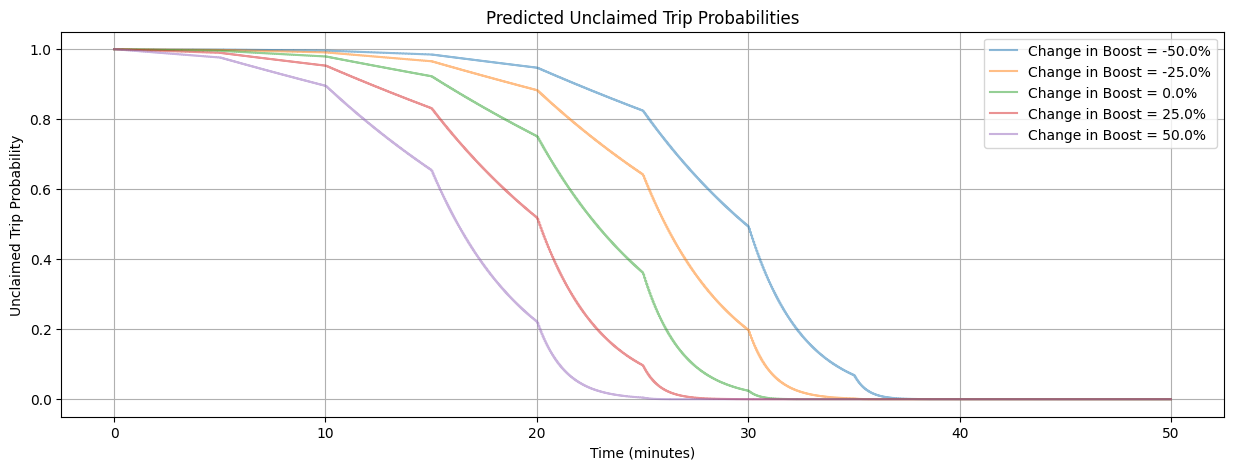

In [6]:
plt.figure(figsize=(15, 5))

for i, total_boost_change in enumerate(total_boost_range):
    label = f"Change in Boost = {total_boost_change}%"
    plt.step(survival_functions.index, survival_functions.iloc[:, i], where='post', label=label, alpha=0.5)

plt.xlabel('Time (minutes)')
plt.ylabel('Unclaimed Trip Probability')
plt.title('Predicted Unclaimed Trip Probabilities')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

A change in total from the current (perhaps expected) average does affect the time until a ride is claimed. This model allows us to simulate the survival functions for any change in boost size. This method can help us determine how much we may need to increase or decrease a boost to avoid overpaying, while ensuring that the expected timeline for a trip to be claimed is in an acceptable range.